In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [3]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

# embedd with tuple of all variables as if each were a single variable
def delayEmbedUnitary(Xin, Yin, eD, eI):
    # eD - embedding dimension, eI - embedding Interval
    n = Xin.shape[0]
    
    if Xin.ndim == 1: # make sure flattened arrays are given 1 width dimension
        p = 1
        Xin = Xin.reshape((n,1))
    else:
        p = Xin.shape[1]
        
    Xout = np.zeros((n-eD*eI, p*(1+eD)))
    for ed in range(eD+1):
        Xout[:,ed*p:(ed+1)*p] = Xin[ed*eI:n-(eD-ed)*eI]
    Yout = Yin[eD*eI:]
    return (Xout, Yout)

In [4]:
# nearest neighbor prediction code

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

# Proper Version
def fNearestNeighbors(S, nNeighbors):
    diff = 0
    for i in range(S.shape[0]-1):
        nearNeighborsIndices = nearestNeighbors(S[i], S, nNeighbors)
        # print("S0: {s1}, NS: {s2}".format(s1=S[i],s2=S[nearNeighborsIndices]))
        for nni in nearNeighborsIndices:
            diff += la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
    avgDiff = diff / ((S.shape[0]-1) * nNeighbors) # geometric mean - seems like lyapunov right?
    
    return avgDiff

In [45]:
end = 2**8
tlen = 2**11
print("Stepsize = {st}".format(st=end/tlen))
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

Stepsize = 0.125


In [46]:
# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# Xr = odeint(Lorenz,t0,t)

# NON STATIONARY VERSION
"""
# Lorenz
rho = lambda t : 28 + 2*np.sin(np.sqrt(2)*2*np.pi*t/tlen) + 4*np.sin(1.687*2*np.pi*t/tlen)# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # np.sin( 4 * 2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
Xr = states
"""
# Rossler
ap = lambda t : 0.2 + 0.1 * np.sin( 4 * 2*np.pi * t / (tlen-2)) # (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.2 # np.sin( 4 * 2*np.pi * t / (tlen-2))
cp = lambda t : 5.7 # beta = 8.0 / 3.0

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states

# END NON STATIONARY

In [47]:
# Composition Function
"""
def compFunc(t):
    a = 3
    b = 5 ** -1
    c = 1.61803398875
    return np.sin(t/c)+np.sin(t / a + np.pi / 2.0) + b

Xr = np.fromfunction(lambda i, j: compFunc(i), (tlen,1))
print(Xr)
"""

'\ndef compFunc(t):\n    a = 3\n    b = 5 ** -1\n    c = 1.61803398875\n    return np.sin(t/c)+np.sin(t / a + np.pi / 2.0) + b\n\nXr = np.fromfunction(lambda i, j: compFunc(i), (tlen,1))\nprint(Xr)\n'

In [48]:
# Logistic Map
"""
r = lambda t : 3.8 # + 0.6 * np.sin(4*2*np.pi*t/tlen)
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
Xr = states


# Density Dependent Maturation
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC
Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
Xr = states


# Generic Linear System
alpha = 1e-1
A = np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])

states = np.ones((tlen, 2))
for i in range(tlen-1):
    states[i+1] = states[i] @ A 

Xr = states
print(Xr)
"""

'\nr = lambda t : 3.8 # + 0.6 * np.sin(4*2*np.pi*t/tlen)\n# r = lambda t : 0.5 * t / tlen + 3.5\nstates = np.zeros((tlen,1))\nstates[0,0] = t0\nfor t in range(1,tlen):\n    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])\nXr = states\n\n\n# Density Dependent Maturation\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\n# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC\nGmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nXr = 

In [49]:
# Read input data from files
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
X = data.to_numpy()
print(X)
"""

'\nfile = "paramecium_didinium - cleaned.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nX = data.to_numpy()\nprint(X)\n'

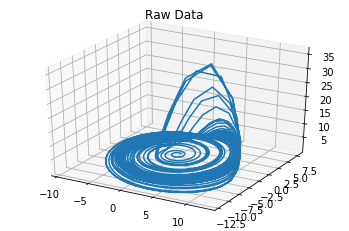

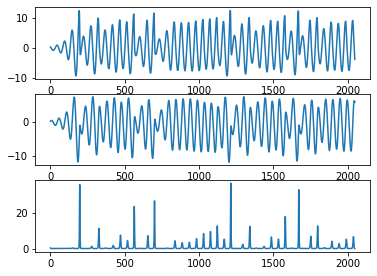

In [50]:
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

""" OBSOLETE - just overembed with large step size, no need to cut things up after the fact.

figSliced = plt.figure(3)
# Sneakyness - only keep every 20th entry to test spikiness hypothesis
X = X[::]

if dim == 1:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],"b") # states
elif dim == 2:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],X[:,1])
else:
    axSliced = fig2.gca(projection="3d")
    axSliced.plot(X[:,0],X[:,1],X[:,2])
axSliced.set_title("Cut")
"""
if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(6,dim*1.5))
    for i in range(dim):
        axTS[i].plot(Xr[:,i])

plt.show()

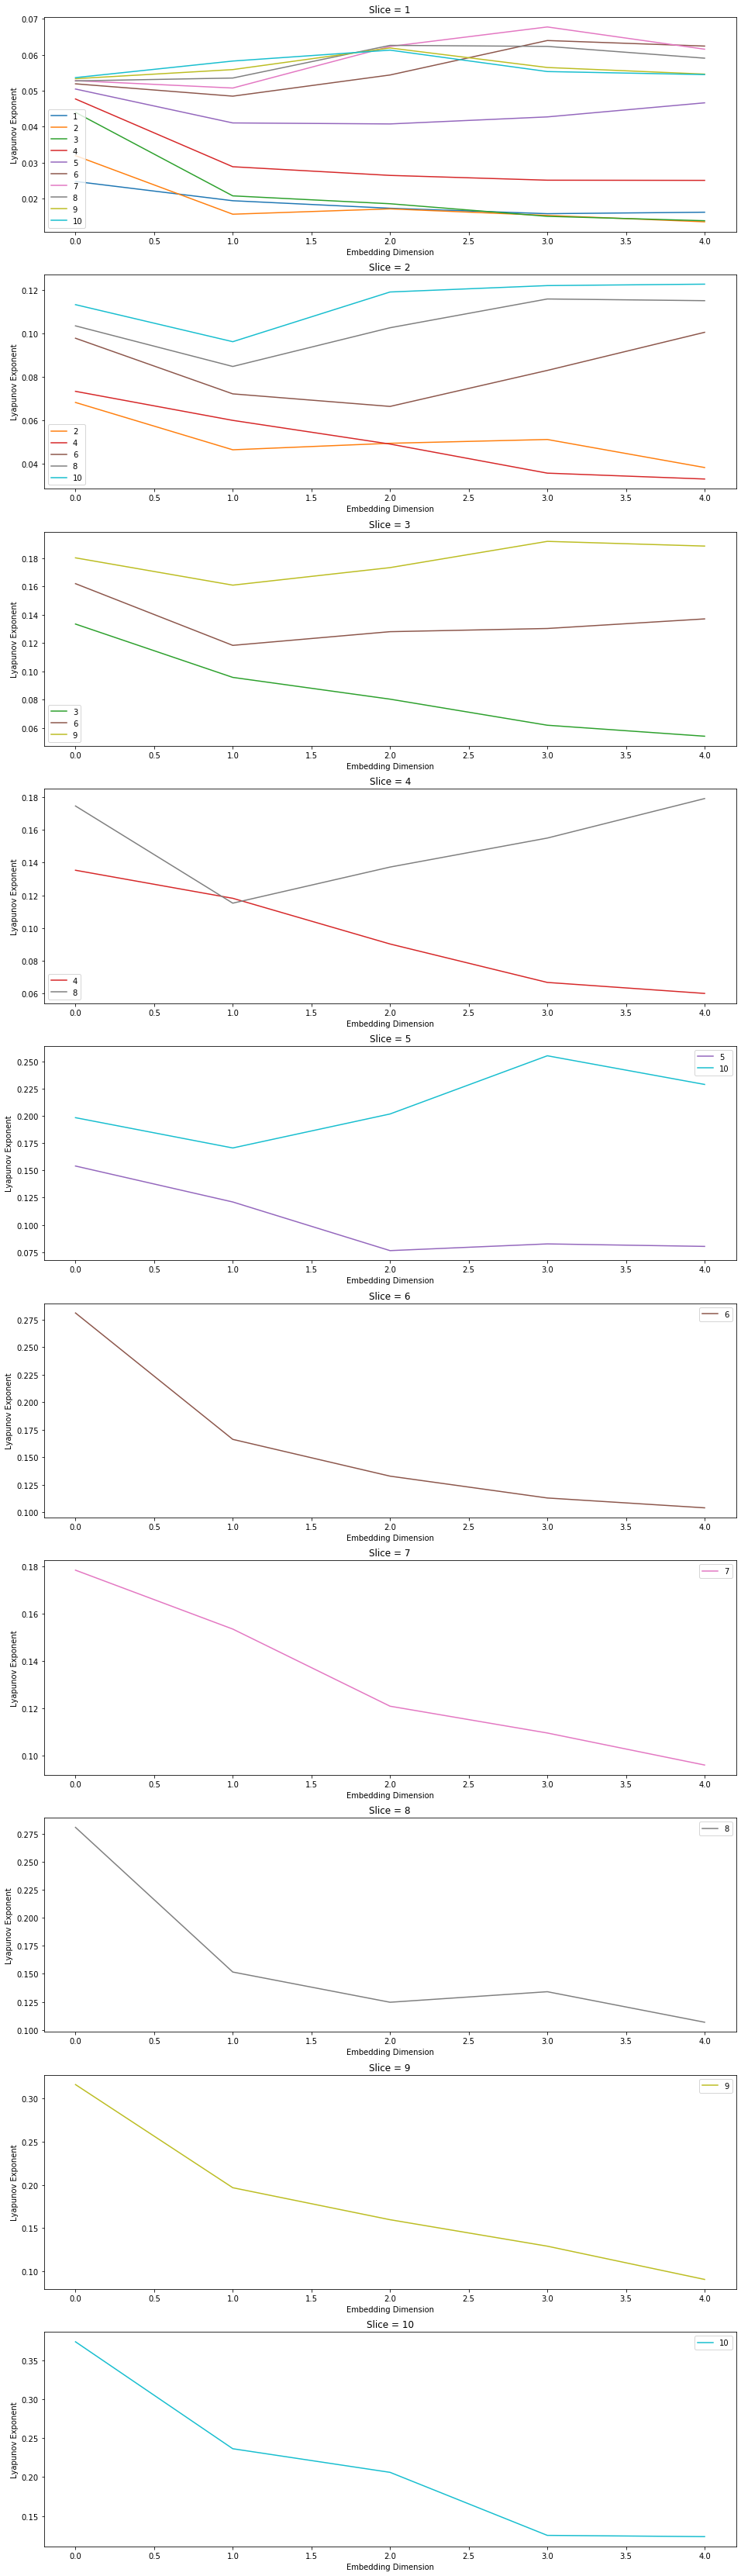

In [51]:
# False Nearest Neighbors Test

# Unitary Embedding Testing
"""
Xt = X[1:]
Y, Yt = delayEmbedUnitary(X, Xt, 2, 2)
print(X)
print(Y)
print(Yt)
"""

J = 10 # max combination embedding
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

l = 5
c = J
st = J

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(c, figsize=(16, 6*c))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for c in range(1, c+1):
    diffs = np.zeros(l)
    lyapExps = np.zeros(l)
    for s in range(1, st+1, 1):
        if c*s <= J:
            for i in range(1, l+1):
                Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
                # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
                # print(Y[:3])
                # d = fNearestNeighbors(Y, 1)
                # diffs[i-1] = d

                lyapExps[i-1] = lyapunovExp(Y)
                # print("{I}, {J}, {K}, st {S} = {D}".format(I=i, J=i, K=i, S=s, D=d))
            # axFNN[(c-1)*2].plot(diffs, label="{e}".format(e=s))
            # axFNN[(c-1)*2+1].plot(lyapExps)
            axFNN[c-1].plot(lyapExps, label="{e}".format(e=s*c),c=colors[c*s-1])
    """
    axFNN[(c-1)*2].legend()
    axFNN[(c-1)*2].set_xlabel("Embedding Dimension")
    axFNN[(c-1)*2].set_ylabel("FNN Distance")
    axFNN[(c-1)*2].set_title("Slice = {ind}".format(ind=c))
    axFNN[(c-1)*2+1].set_xlabel("Embedding Dimension")
    axFNN[(c-1)*2+1].set_ylabel("Lyapunov Exponent")
    """
    axFNN[c-1].legend()
    axFNN[c-1].set_xlabel("Embedding Dimension")
    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
    axFNN[c-1].set_ylabel("Lyapunov Exponent")
    
plt.show()


In [12]:
# Slice
cut = 1
X = Xr[::cut]
tlen = np.floor(tlen / cut)

# Delay Embed
X, _ = delayEmbed(X, X, [3]*dim,1)
# X, _ = delayEmbedUnitary(X, X, 3,5) # << Seems to always suck

In [13]:
# X = (X - X.mean(0) ) / X.std(0) # normalize
print(X)

[[ 0.2677235   0.45510827  0.10285403 ...  0.25008734  0.288351
   0.3333    ]
 [ 0.25025787  0.46644355  0.09250962 ...  0.21753725  0.25008734
   0.288351  ]
 [ 0.23274272  0.47734493  0.08373993 ...  0.18986484  0.21753725
   0.25008734]
 ...
 [-1.6457604   4.42274025  0.48802795 ...  2.0479887   2.46558199
   2.9496496 ]
 [-1.79742734  4.39646744  0.3924982  ...  1.69127879  2.0479887
   2.46558199]
 [-1.94550876  4.36566604  0.31529288 ...  1.38928795  1.69127879
   2.0479887 ]]


In [14]:
# Slow Feature Analysis

def hprime(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    return hx

def standardize(x):
    return (x - np.mean(x, axis=0)) # / np.std(x, axis=0)

In [15]:
np.set_printoptions(precision=4, suppress=True)
# print("X = ", X.shape)
Xst = standardize(X)
# print(Xst.shape, hp.shape)
# zprime = Xst
zprime = hprime(Xst)
c = np.cov(zprime.T, bias=False)
# print("Covariance = ", c, c.shape)

eigval, eigvec = la.eigh(c)
# print("Eigenstuff = ", eigval, eigvec)
print("Eigenvals(shouldn't be near 0) ", eigval)

diagEigVal = np.diag((eigval+1e-10) ** -0.5)

# print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
# print("z = ", z)
print("Mean test(should be 0)", np.mean(z))
print("Covariance test(should be I): \n",np.cov(z.T))

Eigenvals(shouldn't be near 0)  [  -0.       -0.       -0.       -0.       -0.       -0.       -0.
   -0.       -0.       -0.       -0.       -0.       -0.       -0.
   -0.       -0.       -0.       -0.       -0.       -0.       -0.
   -0.       -0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.0002    0.0003    0.0004    0.001     0.0136    0.0348
    0.1328    0.1391    0.2139    1.6201   15.4245   30.9076   46.0967
   64.8876  456.9329 1818.0276 2943.3145 3757.6017 6172.1693]
Mean test(should be 0) -361.09071210164666
Covariance test(should be I): 
 [[ 0.0003 -0.     -

In [16]:
zdot = z[1:,:] - z[:-1,:]

# print((zdot @ zdot.T).round(4))
covzdot = np.cov(zdot.T)
# print(covzdot.shape)
eigValDot, eigVecDot = la.eigh(covzdot)
print("EigenVectors = ", eigVecDot)

a = eigVecDot[:,np.argsort(eigValDot)[0]] # eigVecDot.sort(key=eigValDot)[0]
# print(a)
yt = a @ z.T
print(a.shape, z.shape)

EigenVectors =  [[ 0.1842  0.      0.     ... -0.0003  0.0009 -0.    ]
 [-0.0176 -0.0087  0.0072 ... -0.0021 -0.0004  0.0017]
 [ 0.199   0.0448 -0.001  ... -0.0005 -0.0004 -0.0001]
 ...
 [-0.      0.      0.     ...  0.0035 -0.0001 -0.0005]
 [ 0.     -0.      0.     ... -0.     -0.0002  0.0002]
 [ 0.     -0.     -0.     ...  0.0011  0.0003 -0.0005]]
(90,) (1015, 90)


In [17]:
# Idea - write function that check similarity between true and SFA'd time series

def timeSeriesSimilarity(t1, t2):
    return abs(np.dot(t1,t2) / (la.norm(t1) * la.norm(t2)))

gts = np.fromfunction(lambda i : rho(i/cut), yt.shape , dtype = float)# time series of gmax
# print(gts)
cutoff = 5000

nVec = z.shape[1]
gtsStnd = (gts - np.mean(gts)) / np.std(gts)

diffs = np.zeros(nVec)

for e in range(nVec):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
    aeStnd = ae - np.mean(ae)
    aeStnd = aeStnd / la.norm(aeStnd)
    delta = gtsStnd @ aeStnd.T # delta is the parameter that scales the time series to most closely match the given one
    aeScld = aeStnd * delta
    
    diff = la.norm(gtsStnd - aeScld)
    angDiff = timeSeriesSimilarity(gtsStnd, aeScld)
    # print("Euclidean Difference = {d}, Angular Similarity = {a}".format(d=diff, a=angDiff))
    diffs[e] = angDiff
    # print(delta)

K = 3
figSim, axSim = plt.subplots(K,figsize=(16,K*3))
diffSrtd = np.flip(np.argsort(diffs))
print('Differences = {d}'.format(d=diffs[diffSrtd[:3]]))
for k in range(K):
    e = diffSrtd[k]
    
    ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
    aeStnd = ae - np.mean(ae)
    aeStnd = aeStnd / la.norm(aeStnd)
    delta = gtsStnd @ aeStnd.T
    aeScld = aeStnd * delta
    
    D = la.norm(gtsStnd - aeScld)
    
    axSim[k].margins(y=0.1)
    axSim[k].plot(gtsStnd[:cutoff],c="tab:orange")
    axSim[k].plot(aeScld[:cutoff],c="b")
    # axSim[k].legend("Diff = {dif}".format(dif=D), loc=1)
    axSim[k].set_title("Index = {ind}".format(ind=e))

plt.subplots_adjust(hspace=0.2)
plt.show()

NameError: name 'rho' is not defined

In [ ]:
# gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

# gts = np.fromfunction(lambda i : Gmax(i), yt.shape, dtype = float)# time series of gmax
# gts = np.fromfunction(lambda i : rho(i), yt.shape , dtype = float)# time series of gmax

cutoff = 5000
E = len(eigValDot)
fig, axs = plt.subplots(E+1,figsize=(16,(E+1)*1.75))
axs[0].plot(gts[:cutoff], c="tab:orange")

# print(ae.shape, z.T.shape)
for e in range(E):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]]
    axs[e+1].plot((ae @ z.T)[:cutoff])

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# plt.plot(yt)

"""
# Zoom in on two
specInd = 4
figZ, axZ = plt.subplots(2, figsize=(16,6))
axZ[0].plot(gts[:200,], c="tab:orange")
ae = eigVecDot[:,np.argsort(eigValDot)[specInd]]
axZ[1].plot((ae @ z.T)[:200,])
"""

plt.show()

In [ ]:
expCov = np.array([[1, 0.1, 0.9],[0.1, 1, 0.2],[0.9, 0.2, 1]])
print(expCov)
expVal, expVec = la.eigh(expCov)
print("Eigenvalues ", expVal)
print("Eigenvectors \n", expVec)

scaledVec = expVec * expVal
print(scaledVec, scaledVec[:,0])

covAx = plt.figure().add_subplot(projection="3d")
covAx.axes.set_xlim3d(left=-3,right=3)
covAx.axes.set_ylim3d(bottom=-3,top=3)
covAx.axes.set_zlim3d(bottom=-3,top=3)
covAx.quiver(np.zeros((3)),np.zeros((3)),np.zeros((3)), scaledVec[:,0], scaledVec[:,1], scaledVec[:,2], normalize=False)
plt.show()